# PCoE Autogluon

[PCoE][pcoe]の No.6 Turbofan Engine Degradation Simulation Dataset に対して [Autogluon][autogluon] を利用したAutoMLの実行テスト。

[autogluon]: https://auto.gluon.ai/stable/index.html
[pcoe]: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


# Install autogluon

In [1]:
try:
    import autogluon as ag
except ModuleNotFoundError:
    # https://github.com/awslabs/autogluon/issues/810
    !pip uninstall -y mkl
    !pip install -U pip
    !pip install -U setuptools wheel
    !pip install "mxnet<2.0.0"
    !pip install autogluon
    !pip install -U ipykernel

import autogluon as ag
import autogluon.tabular as agtabular

Uninstalling mkl-2019.0:
  Successfully uninstalled mkl-2019.0
     |████████████████████████████████| 1.6MB 5.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 46.9 MB 43 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 334 kB 7.6 MB/s 
     |████████████████████████████████| 250 kB 36.3 MB/s 
     |████████████████████████████████| 48 kB 5.3 MB/s 
     |████████████████████████████████| 48 kB 5.0 MB/s 
     |████████████████████████████████| 206 kB 17.9 MB/s 
     |████████████████████████████████| 950 kB 28.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████

     |████████████████████████████████| 120 kB 5.7 MB/s 
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 5.5.3 which is incompatible.


# Preset

In [2]:
# default packages
import logging
import pathlib
import zipfile
from typing import Any, Dict, List, Sequence, Tuple

In [3]:
# third party packages
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn.model_selection as skmselection
import tqdm.autonotebook as tqdm

In [4]:
# mode
MODE_DEBUG = True

In [5]:
# logger
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG if MODE_DEBUG else logging.INFO)

In [6]:
# seaborn
sns.set()

# Global parameters

In [7]:
PATH_ARCHIVE = pathlib.Path("turbofun.zip")
PATH_EXTRACT = pathlib.Path("turbofun")

In [8]:
# 利用する変数を定義
COLUMNS_ALL = [
    *[f"op{i:02}" for i in range(3)],
    *[f"sensor{i:02}" for i in range(26)],
]
COLUMNS_INVALID = [
    "op02",
    "sensor01",
    "sensor04",
    "sensor09",
    "sensor15",
    "sensor17",
    "sensor18",
    "sensor21",
    "sensor22",
    "sensor23",
    "sensor24",
    "sensor25",
]
COLUMNS_VALID = sorted(list(set(COLUMNS_ALL) - set(COLUMNS_INVALID)))

COLUMNS_TARGET = ["rul"]

# Load dataset

In [9]:
def download(filename: pathlib.Path) -> None:
    """zipファイルをダウンロード."""
    if filename.exists():
        return

    url = "https://ti.arc.nasa.gov/c/6/"
    res = requests.get(url, stream=True)
    if res.status_code != 200:
        _logger.error(res.status_code)
        return

    with open(filename, "wb") as f:
        for chunk in tqdm.tqdm(res):
            f.write(chunk)


download(PATH_ARCHIVE)

In [10]:
def extractall(src: pathlib.Path, dst: pathlib.Path) -> None:
    """zipファイルを解凍."""
    if not src.exists():
        _logger.error(f"{src} does not exist.")
        return
    if dst.exists():
        _logger.error(f"{dst} exists.")
        return

    with zipfile.ZipFile(src) as zf:
        zf.extractall(dst)


extractall(PATH_ARCHIVE, PATH_EXTRACT)

# Convert data shape

In [11]:
def get_unit_series(df: pd.DataFrame, unit: int) -> Dict[str, Any]:
    """unit単位のnumpy.arrayへ変換する."""
    df_unit = df[df["unit"] == unit].copy()
    df_unit.sort_values(by=["time"], ignore_index=True, inplace=True)
    names_op = [f"op{i:02}" for i in range(3)]
    names_sensor = [f"sensor{i:02}" for i in range(26)]
    data = {
        "unit": unit,
        **{name: df_unit[name].to_numpy().ravel() for name in names_op},
        **{name: df_unit[name].to_numpy().ravel() for name in names_sensor},
    }

    return data


def load_data(filename: pathlib.Path) -> pd.DataFrame:
    """データを読み取り、1セルに1unit分のデータをnumpy.arrayで保持するDataFrameとする."""
    df = pd.read_csv(
        filename,
        header=None,
        sep=" ",
        names=[
            "unit",
            "time",
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ],
    )

    return df


DF_FD001_TRAIN = load_data(PATH_EXTRACT.joinpath("train_FD001.txt"))
DF_FD001_TEST = load_data(PATH_EXTRACT.joinpath("test_FD001.txt"))

In [12]:
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN


In [13]:
display.display(DF_FD001_TEST)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,NaN,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,NaN,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,NaN,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,NaN,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,NaN,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,NaN,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,NaN,NaN,NaN


In [14]:
def load_rul(filepath: pathlib.Path) -> pd.DataFrame:
    """テスト用のRULを読み込む."""
    df = pd.read_csv(
        filepath,
        header=None,
        sep=" ",
        names=["rul", "none"],
    )
    df.drop(["none"], axis=1, inplace=True)
    df["unit"] = range(len(df))
    df.set_index(["unit"], inplace=True)

    return df


DF_FD001_TEST_RUL = load_rul(PATH_EXTRACT.joinpath("RUL_FD001.txt"))
display.display(DF_FD001_TEST_RUL)

,rul
unit,
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59


In [15]:
def create_train_rul(df: pd.DataFrame) -> pd.Series:
    """学習データに対するRULを算出する."""
    df_rul = df.copy()
    df_max_time = df.groupby(["unit"])["time"].max()
    df_rul["rul"] = df_rul.apply(
        lambda x: df_max_time.at[x["unit"]] - x["time"],
        axis=1,
    )

    return df_rul



DF_FD001_TRAIN = create_train_rul(DF_FD001_TRAIN)
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN,1.0


# Data split

In [16]:
def train_test_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """学習用データと検証用データを分割する."""
    units = df["unit"].unique()
    units_train, units_test = skmselection.train_test_split(
        units,
        test_size=0.2,
        random_state=42,
    )

    df_train = df[df["unit"].isin(units_train)]
    df_test = df[df["unit"].isin(units_test)]

    return df_train, df_test


DF_TRAIN, DF_VALID = train_test_split(DF_FD001_TRAIN)

In [17]:
DF_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 192 to 20630
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      16561 non-null  int64  
 1   time      16561 non-null  int64  
 2   op00      16561 non-null  float64
 3   op01      16561 non-null  float64
 4   op02      16561 non-null  float64
 5   sensor00  16561 non-null  float64
 6   sensor01  16561 non-null  float64
 7   sensor02  16561 non-null  float64
 8   sensor03  16561 non-null  float64
 9   sensor04  16561 non-null  float64
 10  sensor05  16561 non-null  float64
 11  sensor06  16561 non-null  float64
 12  sensor07  16561 non-null  float64
 13  sensor08  16561 non-null  float64
 14  sensor09  16561 non-null  float64
 15  sensor10  16561 non-null  float64
 16  sensor11  16561 non-null  float64
 17  sensor12  16561 non-null  float64
 18  sensor13  16561 non-null  float64
 19  sensor14  16561 non-null  float64
 20  sensor15  16561 non-null  

In [18]:
DF_VALID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 18514
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      4070 non-null   int64  
 1   time      4070 non-null   int64  
 2   op00      4070 non-null   float64
 3   op01      4070 non-null   float64
 4   op02      4070 non-null   float64
 5   sensor00  4070 non-null   float64
 6   sensor01  4070 non-null   float64
 7   sensor02  4070 non-null   float64
 8   sensor03  4070 non-null   float64
 9   sensor04  4070 non-null   float64
 10  sensor05  4070 non-null   float64
 11  sensor06  4070 non-null   float64
 12  sensor07  4070 non-null   float64
 13  sensor08  4070 non-null   float64
 14  sensor09  4070 non-null   float64
 15  sensor10  4070 non-null   float64
 16  sensor11  4070 non-null   float64
 17  sensor12  4070 non-null   float64
 18  sensor13  4070 non-null   float64
 19  sensor14  4070 non-null   float64
 20  sensor15  4070 non-null   flo

# Autogluon

In [19]:
def fit(df_train: pd.DataFrame, df_valid: pd.DataFrame) -> agtabular.TabularPredictor:
    """テーブル用の予測気を学習する."""
    presets = "medium_quality_faster_train" if MODE_DEBUG else "best_quality"
    time_limit = 60 if MODE_DEBUG else 3600  # sec

    predictor = agtabular.TabularPredictor(
        label="rul",
        problem_type="regression",
        eval_metric="root_mean_squared_error",
        path="autogluon",
        verbosity=4,
    )
    predictor.fit(
        train_data=df_train,
        time_limit=time_limit,
        presets=presets,
    )

    return predictor


PREDICTOR = fit(
    DF_TRAIN[COLUMNS_VALID + COLUMNS_TARGET],
    DF_VALID[COLUMNS_VALID + COLUMNS_TARGET],
)

Presets specified: ['medium_quality_faster_train']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': None,
 'keep_only_best': False,
 'num_bag_folds': None,
 'num_bag_sets': None,
 'num_stack_levels': None,
 'quantile_levels': None,
 'refit_full': False,
 'save_space': False,
 'set_best_to_refit_full': False,
 'unlabeled_data': None,
 'verbosity': 4}
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "autogluon/"
AutoGluon Version:  0.2.0
Train Data Rows:    16561
Train Data Columns: 17
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12670.21 

[1]	train_set's rmse: 67.5251	valid_set's rmse: 70.0535
[2]	train_set's rmse: 65.7405	valid_set's rmse: 68.3496
[3]	train_set's rmse: 64.1534	valid_set's rmse: 66.828
[4]	train_set's rmse: 62.5682	valid_set's rmse: 65.3194
[5]	train_set's rmse: 61.1788	valid_set's rmse: 63.9845
[6]	train_set's rmse: 59.8358	valid_set's rmse: 62.6949
[7]	train_set's rmse: 58.5465	valid_set's rmse: 61.4767
[8]	train_set's rmse: 57.3792	valid_set's rmse: 60.3839
[9]	train_set's rmse: 56.2676	valid_set's rmse: 59.357
[10]	train_set's rmse: 55.2471	valid_set's rmse: 58.3561
[11]	train_set's rmse: 54.2567	valid_set's rmse: 57.4376
[12]	train_set's rmse: 53.3662	valid_set's rmse: 56.5946
[13]	train_set's rmse: 52.5311	valid_set's rmse: 55.7898
[14]	train_set's rmse: 51.8102	valid_set's rmse: 55.119
[15]	train_set's rmse: 51.1222	valid_set's rmse: 54.4782
[16]	train_set's rmse: 50.4497	valid_set's rmse: 53.8431
[17]	train_set's rmse: 49.841	valid_set's rmse: 53.2665
[18]	train_set's rmse: 49.2643	valid_set's r

Saving autogluon/models/LightGBMXT/model.pkl
	-45.7205	 = Validation root_mean_squared_error score
	3.87s	 = Training runtime
	0.02s	 = Validation runtime
Saving autogluon/models/trainer.pkl
Fitting model: LightGBM ... Training model for up to 53.86s of the 53.83s of remaining time.
	Fitting LightGBM with 'num_gpus': 0, 'num_cpus': 2
	Dropped 0 of 16 features.



[249]	train_set's rmse: 39.6778	valid_set's rmse: 45.8367
[250]	train_set's rmse: 39.6718	valid_set's rmse: 45.8404
[251]	train_set's rmse: 39.6609	valid_set's rmse: 45.8345
[252]	train_set's rmse: 39.649	valid_set's rmse: 45.8415
[253]	train_set's rmse: 39.6379	valid_set's rmse: 45.8419
[254]	train_set's rmse: 39.6295	valid_set's rmse: 45.8464
[255]	train_set's rmse: 39.6201	valid_set's rmse: 45.8481
[256]	train_set's rmse: 39.6081	valid_set's rmse: 45.8514
[257]	train_set's rmse: 39.595	valid_set's rmse: 45.8561
[258]	train_set's rmse: 39.5853	valid_set's rmse: 45.854
[259]	train_set's rmse: 39.5743	valid_set's rmse: 45.8607
[260]	train_set's rmse: 39.5683	valid_set's rmse: 45.8584
[261]	train_set's rmse: 39.5596	valid_set's rmse: 45.8581
[262]	train_set's rmse: 39.5466	valid_set's rmse: 45.8691
[263]	train_set's rmse: 39.5379	valid_set's rmse: 45.87
[264]	train_set's rmse: 39.5315	valid_set's rmse: 45.87
[265]	train_set's rmse: 39.5236	valid_set's rmse: 45.8728
[266]	train_set's rm

Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[1]	train_set's rmse: 67.3501	valid_set's rmse: 69.9633
[2]	train_set's rmse: 65.4509	valid_set's rmse: 68.2079
[3]	train_set's rmse: 63.6804	valid_set's rmse: 66.5571
[4]	train_set's rmse: 62.0333	valid_set's rmse: 65.0516
[5]	train_set's rmse: 60.4931	valid_set's rmse: 63.6538
[6]	train_set's rmse: 59.067	valid_set's rmse: 62.3313
[7]	train_set's rmse: 57.7353	valid_set's rmse: 61.1258
[8]	train_set's rmse: 56.4899	valid_set's rmse: 60.0043
[9]	train_set's rmse: 55.3355	valid_set's rmse: 58.9737
[10]	train_set's rmse: 54.2605	valid_set's rmse: 57.973
[11]	train_set's rmse: 53.2628	valid_set's rmse: 57.0713
[12]	train_set's rmse: 52.3341	valid_set's rmse: 56.233
[13]	train_set's rmse: 51.4711	valid_set's rmse: 55.4644
[14]	train_set's rmse: 50.6576	valid_set's rmse: 54.7412
[15]	train_set's rmse: 49.9143	valid_set's rmse: 54.0646
[16]	train_set's rmse: 49.213	valid_set's rmse: 53.4444
[17]	train_set's rmse: 48.5772	valid_set's rmse: 52.8871
[18]	train_set's rmse: 47.9766	valid_set's r

Saving autogluon/models/LightGBM/model.pkl
	-45.9649	 = Validation root_mean_squared_error score
	0.87s	 = Training runtime
	0.01s	 = Validation runtime
Saving autogluon/models/trainer.pkl
Fitting model: RandomForestMSE ... Training model for up to 52.94s of the 52.9s of remaining time.
	Fitting RandomForestMSE with 'num_gpus': 0, 'num_cpus': 2
	Dropped 0 of 16 features.


[205]	train_set's rmse: 35.8719	valid_set's rmse: 46.1553
[206]	train_set's rmse: 35.8385	valid_set's rmse: 46.1532
[207]	train_set's rmse: 35.822	valid_set's rmse: 46.156
[208]	train_set's rmse: 35.803	valid_set's rmse: 46.152
[209]	train_set's rmse: 35.7826	valid_set's rmse: 46.1619
[210]	train_set's rmse: 35.7581	valid_set's rmse: 46.1568
[211]	train_set's rmse: 35.7315	valid_set's rmse: 46.1487
[212]	train_set's rmse: 35.715	valid_set's rmse: 46.1484
[213]	train_set's rmse: 35.6967	valid_set's rmse: 46.1518
[214]	train_set's rmse: 35.6785	valid_set's rmse: 46.1511
[215]	train_set's rmse: 35.6632	valid_set's rmse: 46.1551
[216]	train_set's rmse: 35.6388	valid_set's rmse: 46.1483
[217]	train_set's rmse: 35.6177	valid_set's rmse: 46.1499
[218]	train_set's rmse: 35.5915	valid_set's rmse: 46.1509
[219]	train_set's rmse: 35.5748	valid_set's rmse: 46.1532
[220]	train_set's rmse: 35.5531	valid_set's rmse: 46.161
[221]	train_set's rmse: 35.5345	valid_set's rmse: 46.1649
[222]	train_set's rm

Saving autogluon/models/RandomForestMSE/model.pkl
	-46.4669	 = Validation root_mean_squared_error score
	32.64s	 = Training runtime
	0.2s	 = Validation runtime
Saving autogluon/models/trainer.pkl
Fitting model: CatBoost ... Training model for up to 19.08s of the 19.04s of remaining time.
	Fitting CatBoost with 'num_gpus': 0, 'num_cpus': 2
	Dropped 0 of 16 features.
	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'RMSE'}


0:	learn: 67.5735147	test: 70.1186605	best: 70.1186605 (0)	total: 57.5ms	remaining: 1.9s
1:	learn: 65.8772024	test: 68.5278570	best: 68.5278570 (1)	total: 65.3ms	remaining: 1.04s
2:	learn: 64.2840560	test: 66.9852472	best: 66.9852472 (2)	total: 70.7ms	remaining: 730ms
3:	learn: 62.7668495	test: 65.5456440	best: 65.5456440 (3)	total: 76.4ms	remaining: 573ms
4:	learn: 61.3836369	test: 64.2210753	best: 64.2210753 (4)	total: 81.8ms	remaining: 475ms
5:	learn: 60.0751654	test: 62.9697371	best: 62.9697371 (5)	total: 87.5ms	remaining: 409ms
6:	learn: 58.8308888	test: 61.7640952	best: 61.7640952 (6)	total: 92.9ms	remaining: 358ms
7:	learn: 57.6761951	test: 60.6739235	best: 60.6739235 (7)	total: 98.2ms	remaining: 319ms
8:	learn: 56.6346445	test: 59.7013621	best: 59.7013621 (8)	total: 104ms	remaining: 289ms
9:	learn: 55.6284420	test: 58.7431749	best: 58.7431749 (9)	total: 110ms	remaining: 265ms
10:	learn: 54.6852675	test: 57.8183961	best: 57.8183961 (10)	total: 124ms	remaining: 259ms
11:	learn: 5

Saving autogluon/models/CatBoost/model.pkl
	-45.8622	 = Validation root_mean_squared_error score
	1.94s	 = Training runtime
	0.0s	 = Validation runtime
Saving autogluon/models/trainer.pkl
Fitting model: ExtraTreesMSE ... Training model for up to 17.11s of the 17.08s of remaining time.
	Fitting ExtraTreesMSE with 'num_gpus': 0, 'num_cpus': 2
	Dropped 0 of 16 features.


237:	learn: 40.3528736	test: 45.8972465	best: 45.8622277 (159)	total: 1.39s	remaining: 10.8s
238:	learn: 40.3472620	test: 45.8974943	best: 45.8622277 (159)	total: 1.4s	remaining: 10.8s
239:	learn: 40.3350312	test: 45.8905147	best: 45.8622277 (159)	total: 1.4s	remaining: 10.8s
240:	learn: 40.3236510	test: 45.8932606	best: 45.8622277 (159)	total: 1.41s	remaining: 10.8s
241:	learn: 40.3190278	test: 45.8915628	best: 45.8622277 (159)	total: 1.41s	remaining: 10.8s
242:	learn: 40.3184286	test: 45.8914868	best: 45.8622277 (159)	total: 1.42s	remaining: 10.8s
243:	learn: 40.3066739	test: 45.8926885	best: 45.8622277 (159)	total: 1.42s	remaining: 10.8s
244:	learn: 40.2996994	test: 45.8924726	best: 45.8622277 (159)	total: 1.43s	remaining: 10.7s
245:	learn: 40.2993199	test: 45.8925972	best: 45.8622277 (159)	total: 1.43s	remaining: 10.7s
246:	learn: 40.2876810	test: 45.8885475	best: 45.8622277 (159)	total: 1.44s	remaining: 10.7s
247:	learn: 40.2778149	test: 45.8907107	best: 45.8622277 (159)	total: 1.

Saving autogluon/models/ExtraTreesMSE/model.pkl
	-45.8561	 = Validation root_mean_squared_error score
	8.91s	 = Training runtime
	0.2s	 = Validation runtime
Saving autogluon/models/trainer.pkl
Fitting model: NeuralNetFastAI ... Training model for up to 7.25s of the 7.21s of remaining time.
	Fitting NeuralNetFastAI with 'num_gpus': 0, 'num_cpus': 2
Fitting Neural Network with parameters {'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}...
	Dropped 0 of 16 features.
Using 0/0 categorical features
Using 16 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=16, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentu

In [20]:
PREDICTOR.leaderboard()

                 model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2  -45.657281       0.244074  16.192222                0.005898           0.608571            2       True          9
1           LightGBMXT  -45.720517       0.018658   3.867265                0.018658           3.867265            1       True          3
2        ExtraTreesMSE  -45.856060       0.203635   8.910271                0.203635           8.910271            1       True          7
3             CatBoost  -45.862228       0.003825   1.939829                0.003825           1.939829            1       True          6
4             LightGBM  -45.964893       0.012058   0.866286                0.012058           0.866286            1       True          4
5      RandomForestMSE  -46.466879       0.204180  32.635588                0.204180          32.635588            1       True          5
6       KNeighborsUnif  -52

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-45.657281,0.244074,16.192222,0.005898,0.608571,2,True,9
1,LightGBMXT,-45.720517,0.018658,3.867265,0.018658,3.867265,1,True,3
2,ExtraTreesMSE,-45.856060,0.203635,8.910271,0.203635,8.910271,1,True,7
3,CatBoost,-45.862228,0.003825,1.939829,0.003825,1.939829,1,True,6
4,LightGBM,-45.964893,0.012058,0.866286,0.012058,0.866286,1,True,4
5,RandomForestMSE,-46.466879,0.204180,32.635588,0.204180,32.635588,1,True,5
6,KNeighborsUnif,-52.264067,0.877543,0.040120,0.877543,0.040120,1,True,1
7,KNeighborsDist,-52.382137,0.740641,0.019594,0.740641,0.019594,1,True,2
8,NeuralNetFastAI,-128.541838,0.076452,13.717243,0.076452,13.717243,1,True,8


## Results

In [21]:
def predict(
    predictor: agtabular.TabularPredictor,
    model: str,
    df: pd.DataFrame,
    columns: List[str],
    units: List[int],
) -> None:
    """予測結果を可視化する."""
    df_target = df[columns]

    df_results = df[["unit", "time", "rul"]].copy()
    df_results["pred"] = predictor.predict(df_target, model=model)

    for unit in units:
        df_target = df_results[df_results["unit"] == unit]
        fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
        ax = axes
        ax.plot(df_target["time"], df_target["rul"], label="rul")
        ax.plot(df_target["time"], df_target["pred"], label="pred")
        ax.set_title(f"unit{unit:02}")
        plt.show()
        plt.close()
        fig.clf()

Loading: autogluon/models/KNeighborsUnif/model.pkl
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 3.335
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400

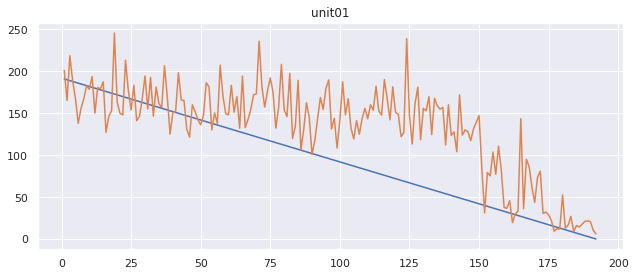

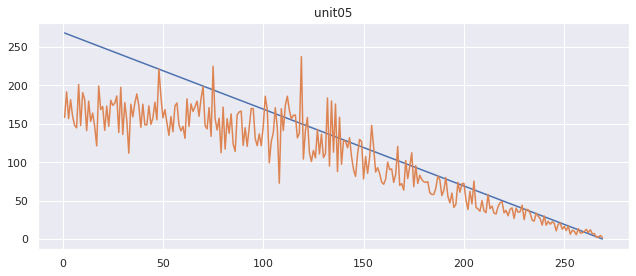

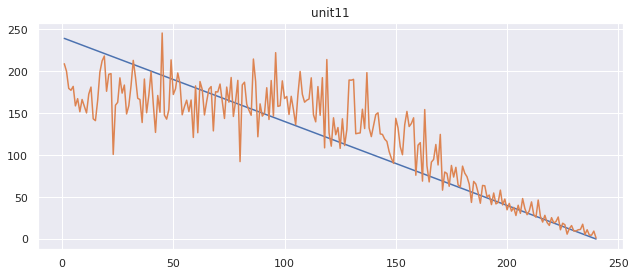

In [22]:
predict(
    PREDICTOR,
    PREDICTOR.get_model_names()[0],
    DF_VALID,
    COLUMNS_VALID + COLUMNS_TARGET,
    DF_VALID["unit"].unique()[:3],
)

In [23]:
# 特徴量重要度を確認
PREDICTOR.feature_importance(
    DF_VALID[COLUMNS_VALID + COLUMNS_TARGET],
    model=PREDICTOR.get_model_names()[0],
    subsample_size=DF_VALID.shape[0],
    time_limit=60 if MODE_DEBUG else 600,
    num_shuffle_sets=None if MODE_DEBUG else 10,
)

Loading: autogluon/models/KNeighborsUnif/model.pkl
Computing feature importance via permutation shuffling for 17 features using 4070 rows with 10 shuffle sets... Time limit: 60s...
	547.46s	= Expected runtime (54.75s per shuffle set)
	43.15s	= Actual runtime (Completed 1 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
sensor03,18.962694,NaN,NaN,1,NaN,NaN
sensor08,7.841053,NaN,NaN,1,NaN,NaN
sensor02,4.025741,NaN,NaN,1,NaN,NaN
sensor13,3.506716,NaN,NaN,1,NaN,NaN
sensor06,0.852385,NaN,NaN,1,NaN,NaN
sensor11,0.536226,NaN,NaN,1,NaN,NaN
sensor16,0.519570,NaN,NaN,1,NaN,NaN
sensor10,0.162786,NaN,NaN,1,NaN,NaN
sensor20,0.047043,NaN,NaN,1,NaN,NaN
sensor14,0.007852,NaN,NaN,1,NaN,NaN
